In [1]:
%matplotlib inline  

In [2]:
import scipy.io as sio
import scipy.signal as scs
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as npml


### functions definition

In [13]:
def reconstruct_rf_img(rf, x_grid, z_grid,
                       pitch, fs, fc, c,
                       tx_aperture, tx_focus, tx_angle,
                       n_pulse_periods, tx_mode='lin', n_first_samples=0,
                       ):

    """
    Function for image reconstruction using delay-and-sum approach.

    :param rf: 3D array of rf signals before beamforming
    :param x_grid: vector of pixel x coordinates [m]
    :param z_grid: vector of pixel z coordinates [m]
    :param pitch: the distance between contiguous elements [m]
    :param fs: sampling frequency [Hz]
    :param fc: carrier frequency [Hz]
    :param n_pulse_periods: the length of the pulse in periods
    :param n_first_samples: samples recorded before transmission
    :param c: assumed speed of sound [m/s]
    :param tx_mode: imaging mode - lin (classical),
                                   sta (synthetic transmit aperture)
                                   pwi (plane wave imaging)
    :param tx_focus: transmit focus [m]
    :param tx_angle: transmit angle [radians]
    :return: rf beamformed image

    """

    # making x and z_grid 'vertical vector' (should be more user friendly in future!)
    temp = z_grid[np.newaxis]
    z_grid = temp.T

    # getting some size parameters
    n_samples, n_channels, n_transmissions  = rf.shape
    z_size = max(z_grid.shape)
    x_size = max(x_grid.shape)

    # probe/transducer width
    probe_width = (n_channels-1)*pitch

    # x coordinate of transducer elements
    element_xcoord = np.linspace(-probe_width/2, probe_width/2, n_channels)

    # initial delays [s]
    delay0 = n_first_samples/fs
    burst_factor = 0.5*n_pulse_periods/fc
    is_lin_or_sta = tx_mode == 'lin' or tx_mode == 'sta'
    if is_lin_or_sta and tx_focus > 0:
        focus_delay = (np.sqrt(((tx_aperture-1)*pitch/2)**2 + tx_focus**2)
                       - tx_focus)/c
    else:
        focus_delay = 0

    init_delay = focus_delay + burst_factor - delay0

    # Delay & Sum
    # add zeros as last samples.
    # If a sample is out of range 1: nSamp, then use the sample no.nSamp + 1 which is 0.
    # to be checked if it is faster than irregular memory access.
    tail = np.zeros((1, n_channels, n_transmissions))
    rf = np.concatenate((rf, tail))

    # buffers allocation
    rf_tx = np.zeros((z_size, x_size, n_transmissions))
    weight_tx = np.zeros((z_size, x_size, n_transmissions))

    # loop over transmissions
    for itx in range(0, n_transmissions):

        # calculate tx delays and apodization

        # classical linear scanning
        # (only a narrow stripe is reconstructed  at a time, no tx apodization)
        if tx_mode == 'lin':

            # difference between image point x coordinate and element x coord
            xdifference = np.array(x_grid-element_xcoord[itx])

            # logical indexes of valid x coordinates
            lix_valid = (xdifference > (-pitch/2)) & (xdifference <= (pitch/2))
            n_valid = np.sum(lix_valid)

            # ix_valid = list(np.nonzero(lix_valid))
            tx_distance = npml.repmat(z_grid, 1, n_valid)
            tx_apodization = np.ones((z_size, n_valid))
            # TODO: Should be better image close to the transducer (apodization)

        # synthetic transmit aperture method
        elif tx_mode == 'sta':
            lix_valid = np.ones((x_size), dtype=bool)
            tx_distance = np.sqrt((z_grid - tx_focus)**2
                                + (x_grid - element_xcoord[itx])**2
                          )

            tx_distance = tx_distance*np.sign(z_grid - tx_focus) + tx_focus

            f_number = max(np.append(abs(z_grid - tx_focus), 1e-12))\
                        /abs(x_grid - element_xcoord[itx])*0.5

            tx_apodization = f_number > 2
            

        elif tx_mode == 'pwi':
            lix_valid = np.ones((x_size), dtype=bool)

            if tx_angle[itx] >= 0:
                first_element = 0
            else:
                first_element = n_channels-1


            tx_distance = \
                (x_grid - element_xcoord[first_element]) * np.sin(tx_angle[itx])\
                + z_grid * np.cos(tx_angle[itx])

            r1 = (x_grid - element_xcoord[0]) * np.cos(tx_angle[itx])\
                 - z_grid * np.sin(tx_angle[itx])

            r2 = (x_grid - element_xcoord[-1]) * np.cos(tx_angle[itx])\
                 - z_grid * np.sin(tx_angle[itx])

            tx_apodization = (r1 >= 0) & (r2 <= 0)

        else:
            raise ValueError('unknown reconstruction mode!')

            # buffers allocation
        rf_rx = np.zeros((z_size, x_size, n_channels))
        weight_rx = np.zeros((z_size, x_size, n_channels))

        # loop over elements
        for irx in range(0, n_channels):

            # calculate rx delays and apodization
            rx_distance = np.sqrt((x_grid[lix_valid] - element_xcoord[irx])**2
                                  + z_grid**2)
            f_number = abs(z_grid/(x_grid[lix_valid] - element_xcoord[irx])*0.5)
            rx_apodization = f_number > 2

            # calculate total delays [s]
            delays = init_delay + (tx_distance + rx_distance)/c
            

            # calculate sample number to be used in reconstruction
            samples = delays*fs + 1
            

            out_of_range = (0 > samples) | (samples > n_samples-1)
            samples[out_of_range] = n_samples

            # calculate rf samples (interpolated) and apodization weights
            rf_raw_line = rf[:, irx, itx]
            ceil_samples = np.ceil(samples).astype(int)
            floor_samples = np.floor(samples).astype(int)

            rf_rx[:, lix_valid, irx] = rf_raw_line[floor_samples]*(1 - (samples % 1))\
                                       + rf_raw_line[ceil_samples]*(samples % 1)

            weight_rx[:, lix_valid, irx] = tx_apodization * rx_apodization

            # modulate if iq signal is used (to trzeba sprawdzic, bo pisane 'na rybke')
            is_data_complex = np.nonzero(np.imag(rf_rx))[0].size
            if is_data_complex:
                # TODO: przetestowac
                rf_rx[:, lix_valid, irx] = rf_rx[:, lix_valid, irx] \
                                           * np.exp(1j*2*np.pi*fc*delays)
                print('complex data')

        # calculate rf and weights for single tx
        rf_tx[:, :, itx] = np.sum(rf_rx * weight_rx, axis=2)
        weight_tx[:, :, itx] = np.sum(weight_rx, axis=2)

        # show progress
        percentage = round((itx+1)/n_transmissions*1000)/10
        if itx == 0:
            print(percentage, '%', end='')
        elif itx == n_transmissions-1:
            print('\r', percentage, '%')
        else:
            print('\r', percentage, '%', end='')

    # calculate final rf image
    rf_image = np.sum(rf_tx, axis=2)/np.sum(weight_tx, axis=2)

    return rf_image


def load_simulated_data(file, verbose=1):
    """
    The function loads data from simulation
    :param file: path2file/filename
    :param verbose: if 1 data keys are printed
    :return:
    """

    matlab_data = sio.loadmat(file)

    c = matlab_data.get('sos')
    c = np.float(c)

    fc = matlab_data.get('fn')
    fc = np.float(fc)

    fs = matlab_data.get('fs')
    fs = np.float(fs)

    n_elements = matlab_data.get('nElem')
    n_elements = np.int(n_elements)
    


    pulse_periods = matlab_data.get('nPer')
    pulse_periods = np.int(pulse_periods)

    pitch = matlab_data.get('pitch')
    pitch = np.float(pitch)


    if 'txAng' in matlab_data:
        tx_angle = matlab_data.get('txAng')
        tx_angle = np.radians(tx_angle)
        tx_angle = tx_angle.T
        # tx_angle = np.int(tx_angle)
    else:
        tx_angle = 0



    if 'txAp' in matlab_data:
        tx_aperture = matlab_data.get('txAp')
        tx_aperture = np.int(tx_aperture)
    else:
        tx_aperture = 1

    if 'txFoc' in matlab_data:
        tx_focus = matlab_data.get('txFoc')
        tx_focus = np.float(tx_focus)
    else:
        tx_focus = 0


    if 'rfLin' in matlab_data:
        rf = matlab_data.get('rfLin')
        mode = 'lin'
        
    if 'rfPwi' in matlab_data:
        rf = matlab_data.get('rfPwi')
        mode = 'pwi'

    if 'rfSta' in matlab_data:
        rf = matlab_data.get('rfSta')
        mode = 'sta'

    if verbose:
        print('input data keys: ', matlab_data.keys())
        print(' ')
        print(' ')
        print('mode:', mode)
        print('speed of sound: ', c)
        print('sampling frequency: ', fs)
        print('pulse (carrier) frequency: ', fc)
        print('pitch: ', pitch)
        print('aperture length: ', n_elements)
        print('focal length: ', tx_focus)
        print('subaperture length: ', tx_aperture)
        print('transmission angles: ', tx_angle.T)
        print('number of pulse periods: ', pulse_periods)



    return [rf, c, fs, fc, pitch, tx_focus, tx_angle, tx_aperture, n_elements, pulse_periods, mode]

def calculate_envelope(rf):
    """
    The function calculate envelope using hilbert transform
    :param rf:
    :return: envelope image
    """
    envelope = np.abs(scs.hilbert(rf, axis=0))
    return envelope

def make_bmode_image(rf_image, x_grid, y_grid, draw_colorbar=1):
    """
    The function for creating b-mode image
    :param rf_image: 2D rf image
    :param x_grid: vector of x coordinates
    :param y_grid: vector of y coordinates
    :return:
    """
    dx=x_grid[1]-x_grid[0]
    dy=y_grid[1]-y_grid[0]

    # calculate envelope
    amplitude_image = calculate_envelope(rf_image)

    # convert do dB
    max_image_value = np.max(amplitude_image)
    bmode_image = np.log10(amplitude_image / max_image_value) * 20

    # calculate ticks and labels
    n_samples, n_lines = rf_image.shape
    image_height = (n_samples - 1)*dy
    image_height = z_grid[-1] - z_grid[0]
    # max_depth = image_depth + depth0
    # max_depth = z_grid[-1]
    # image_width = (n_lines - 1)*dx
    image_width = x_grid[-1] - x_grid[0]
    image_proportion = image_height/image_width

    n_xticks = 4
    n_yticks = round(n_xticks * image_proportion)

    xticks = np.linspace(0, n_lines-1, n_xticks)
    xtickslabels = np.linspace(x_grid[0], x_grid[-1], n_xticks)*1e3
    xtickslabels = np.round(xtickslabels, 1)

    yticks = np.linspace(0, n_samples-1, n_yticks)
    ytickslabels = np.linspace(z_grid[0], z_grid[-1], n_yticks)*1e3
    ytickslabels = np.round(ytickslabels, 1)

    # calculate data aspect for proper image proportions
    data_aspect = dy/dx

    # show the image
    plt.imshow(bmode_image,
                    interpolation='bicubic',
                    aspect=data_aspect,
                    cmap='gray',
                    vmin=-60, vmax=0
                    )

    plt.xticks(xticks, xtickslabels)
    plt.yticks(yticks, ytickslabels)

    if draw_colorbar:
        cbar = plt.colorbar()
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel('[dB]', rotation=90)
        plt.xlabel('[mm]')
        plt.ylabel('[mm]')
        plt.show()

        
        
        
        


### loading data

In [4]:
# path to data file

# # mode = 'sta'
# # mode = 'pwi'
mode = 'lin'

if mode == 'sta':
    file = '/media/linuser/data01/praca/us4us/' \
         'us4us_testData/dataSets02/rfSta_field.mat'
    print('STA mode')
elif mode == 'pwi':
    file = '/media/linuser/data01/praca/us4us/' \
           'us4us_testData/dataSets02/rfPwi_field.mat'
    print('PWI mode')
elif mode == 'lin':
    file = '/media/linuser/data01/praca/us4us/' \
           'us4us_testData/dataSets02/rfLin_field.mat'
    print('conventional mode')
else:
    raise ValueError('unknown reconstruction mode!')



# ippt
# file = '/home/linuser/us4us/usgData/rfLin_field.mat'


       

# load data
[rf, c, fs, fc, pitch,
tx_focus, tx_angle, tx_aperture,
n_elements, pulse_periods, mode] = load_simulated_data(file, 1)


conventional mode
input data keys:  dict_keys(['__header__', '__version__', '__globals__', 'fn', 'fs', 'nElem', 'nPer', 'pitch', 'rfLin', 'sos', 'txAp', 'txFoc', 'txAng'])
 
 
mode: lin
speed of sound:  1540.0
sampling frequency:  65000000.0
pulse (carrier) frequency:  5000000.0
pitch:  0.00021
aperture length:  192
focal length:  0.02
subaperture length:  48
transmission angles:  [[0.]]
number of pulse periods:  2


### reconstruction - universal approach (pk)

In [5]:
# define grid for reconstruction (imaged area)
x_grid = np.linspace(-3*1e-3, 3*1e-3, 16)
z_grid = np.linspace(9.5*1e-3, 11.*1e-3, 64)

# reconstruct data
rf_image = reconstruct_rf_img(rf, x_grid, z_grid,
                           pitch, fs, fc, c,
                           tx_aperture, tx_focus, tx_angle,
                           pulse_periods, tx_mode=mode
                           )


 100.0 %


### make an image

/home/linuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:316: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/linuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:317: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


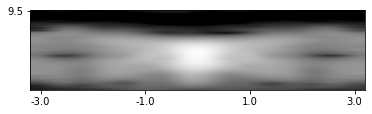

In [6]:
make_bmode_image(rf_image, x_grid, z_grid, 0)

### reconstruction from classical scheme data - alternative approach

In [113]:
def compute_delays_lin(n_samples, aperture, fs, c, focus, pitch, depth0=0, delay0=17):

    """
    Computes delay matrix for given parameters.
    Classical scheme (lin)

    :param n_samples: number of samples to consider
    :param n_channels: number of channels to consider
    :param fs: transducer's sampling frequency [Hz]
    :param c: speed of sound [m/s]
    :param focus: if float or single element list focus is y focal coordinate.
                  If two element list, its [x,y] focal coordinates.
    :param pitch: transducer's pitch [m]
    :param depth0: the starting depth [m]
    :param delay0: hardware delay
    :return: A delay matrix (nSamp, nChan) [samples]
    """

    # length of transducer
    aperture_length = (aperture - 1) * pitch

    # check if focus is scalar or vector
    if type(focus) == float or len(focus) == 1:
        x_focus = aperture_length/2
        y_focus = focus
    else:
        x_focus, y_focus = focus

    # The distance from the line origin along y axis. [m]
    y_grid = np.arange(0, n_samples) / fs * c / 2 + depth0

    # x coordinates of transducer elements
    element_position = np.arange(0, aperture) * pitch

    # Make y_grid a column vector: (n_samples, 1).
    y_grid = y_grid.reshape((-1, 1))

    # Make element position a row vector: (1, n_channels).
    element_position = element_position.reshape((1, -1))

    # distances between elements and imaged point
    tx_distance = y_grid
    rx_distance = np.sqrt((x_focus - element_position)**2 + y_grid**2)
    total_distance = tx_distance + rx_distance

    # delay related with focusing
    if x_focus > aperture_length/2:
        focus_delay = ((x_focus**2 + y_focus**2)**0.5 - y_focus)/c
    else:
        focus_delay = (((aperture_length-x_focus)**2 + y_focus**2)**0.5 - y_focus)/c

    path_delay = (total_distance/c)
    delays = path_delay + focus_delay
    delays = delays * fs + 1
    delays = np.round(delays)
    delays += delay0
    delays = delays.astype(int)

    return delays


def beamforming_line_lin(rf, delays, n_samples):
    """
    Beamforms one line  using delay and sum algorithm.

    :param rf: input RF data of shape (n_samples, n_channels, nLines)
    :param delays: delay matrix of shape (n_samples, n_channels)
    :return: beamformed single RF line
    """
    n_samples, n_channels = delays.shape
    the_line = np.zeros((n_samples))
    for channel in range(n_channels):
        channel_delays = delays[:, channel]
        # only sample indexes smaller than n_samples are correct
        bad_samples_li = channel_delays >= n_samples
        channel_delays[bad_samples_li] = n_samples-1
        the_line += rf[channel_delays, channel]

    return the_line


def beamforming_image_lin(rf, tx_aperture, fs, c, focus, pitch):
    """
    Beamforms image usign lineBeamform function

    :param rf: input RF data of shape (n_samples, n_channels, n_lines)
    :param delays: delay matrix of shape (n_samples, n_channels)
    :return: beamformed RF image
    """
    
    n_samples, n_channels, n_lines = rf.shape
    delays = compute_delays_lin(n_samples, tx_aperture, fs, c, focus, pitch, depth0=0, delay0=17)
    image = np.zeros((n_samples, n_lines))
    for i_line in range(n_lines):
        rf_line = rf[:, i_line:(i_line + tx_aperture), i_line]
        this_line = beamforming_line_lin(rf_line, delays, n_samples)
        image[:, i_line] = this_line

    return image


/home/linuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:316: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/linuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:317: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


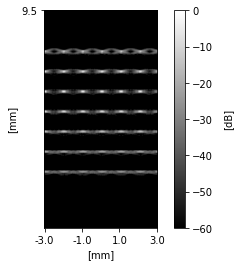

In [119]:
# define grid for reconstruction (imaged area)
x_grid = np.linspace(-3*1e-3, 3*1e-3, 16)
z_grid = np.linspace(9.5*1e-3, 11.*1e-3, 64)

# compute delays
# delays = compute_delays_lin(3000, tx_aperture, fs, c, [15 * pitch, tx_focus], pitch)

# image beamforming
rf_cut = rf[:, :, 24:-26]
# print('rf_cut:', rf_cut.shape)
rf_image = beamforming_image_lin(rf_cut, tx_aperture, fs, c, tx_focus, pitch)

# show bmode image
make_bmode_image(rf_image, x_grid, z_grid, draw_colorbar=1)

In [74]:
temp = [1,2,3,4]
temp = np.array(temp)
temp = temp[temp>2]
temp[0]

3